In [68]:
import os
import cv2
import pickle
import matplotlib.pyplot as plt
import random
import pandas as pd
from skimage.metrics import structural_similarity as ssim

In [69]:
correl_threshold = 0.5
similarity_index_threshold = 0.0
ssim_matches_limit = 100
sift_features_limit = 1000
lowe_ratio = 0.75
predictions_count = 4
len_query_path = 1

In [70]:
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)
flann = cv2.FlannBasedMatcher(index_params,search_params)

In [71]:
def imlist(path):
    return [os.path.join(path, f) for f in os.listdir(path)]

In [72]:
def imshow(im_title, im):
    plt.figure(figsize=(5,5))
    plt.title(im_title)
    plt.axis("off")
    if len(im.shape) == 2:
        plt.imshow(im, cmap = "gray")
    else:
        im_display = cv2.cvtColor(im, cv2.COLOR_RGB2BGR)
        plt.imshow(im_display)
    plt.show()

In [73]:
train_paths = []
train_path = "train_images/"
for root, dirs, files in os.walk(train_path):
     for file in files:
        train_paths.append((os.path.join(root, file)))
len(train_paths)

130

In [74]:
query_path = "query_images/"
query_paths = imlist(query_path)
len_query_path = len(query_paths)
print(len_query_path)

4


In [75]:
%%time

hist_train = []

for path in train_paths:
    image = cv2.imread(path)
   
    if image is None:
        continue

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    hist = cv2.calcHist([image], [0, 1, 2], None, [8, 8, 8],[0, 256, 0, 256, 0, 256])
    hist = cv2.normalize(hist, None)
    hist_train.append((path,hist))
    
len(hist_train)

CPU times: total: 1.52 s
Wall time: 1.06 s


130

In [76]:
with open('train_hist_data.pkl', 'wb') as f:
    pickle.dump(hist_train, f)

In [77]:
with open('train_hist_data.pkl', 'rb') as f:
    hist_train = pickle.load(f)

len(hist_train)

130

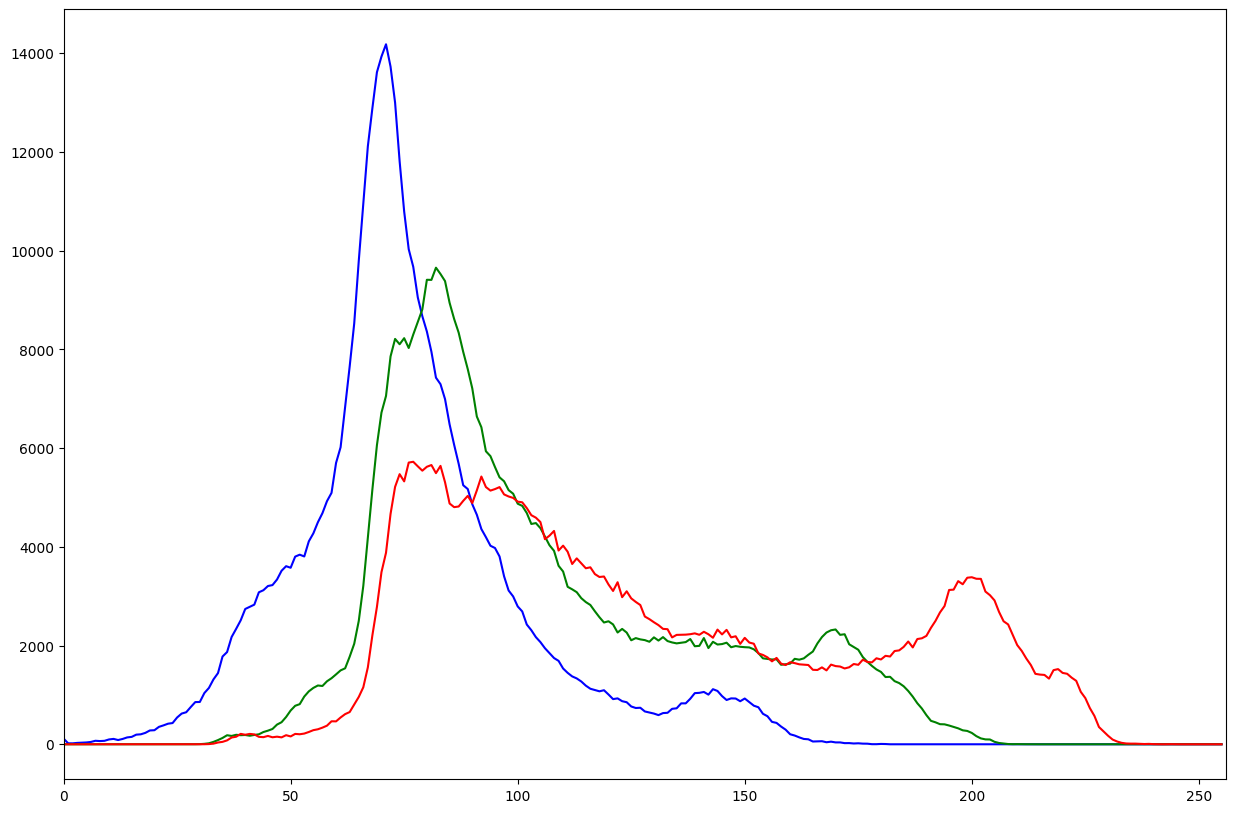

In [79]:
img_path = "query_images/7170b5de-5464-40f7-baa8-4a05b9626505.jpg"
img = cv2.imread(img_path)
color = ('b','g','r')
plt.figure(figsize=(15,10))
for i,col in enumerate(color):
    histr = cv2.calcHist([img],[i],None,[256],[0,256])
    plt.plot(histr,color = col)
    plt.xlim([0,256])
plt.show()

In [80]:
%%time

hist_query = []
for path in query_paths:
    image = cv2.imread(path)
    
    if image is None:
        continue
    
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    hist = cv2.calcHist([image], [0, 1, 2], None, [8, 8, 8],[0, 256, 0, 256, 0, 256])
    hist = cv2.normalize(hist, None)
    hist_query.append((path,hist))

CPU times: total: 62.5 ms
Wall time: 64.9 ms


In [81]:
%%time

hist_matches = []
for i in range(len(hist_query)):
    matches = []
    for j in range(len(hist_train)):
        cmp = cv2.compareHist(hist_query[i][1], hist_train[j][1], cv2.HISTCMP_CORREL)
        if cmp > correl_threshold:
            matches.append((cmp,hist_train[j][0]))
    matches.sort(key=lambda x : x[0] , reverse = True)
    hist_matches.append((hist_query[i][0],matches))

CPU times: total: 0 ns
Wall time: 2.99 ms


In [82]:
hit_count_hist = 0
miss_count_hist = 0

for i in range(len(hist_matches)):
    q_text = hist_matches[i][0].split("/")[-1]
    p_text = []
    for j in range(len(hist_matches[i][1])):
        text = hist_matches[i][1][j][1].split("/")[-1]
        p_text.append(text)
    if q_text in p_text:
        hit_count_hist += 1
    else:
        miss_count_hist += 1

print("query set is", query_path.split("/")[-0])        
print("\n")
print("Total number of images = ",len(hist_matches))
print("Number of correctly retrieved images = ",hit_count_hist)
print("Number of images that could not be retrieved = ",miss_count_hist)

query set is query_images


Total number of images =  4
Number of correctly retrieved images =  4
Number of images that could not be retrieved =  0


In [83]:
def similarity_index(q_path,m_path):
    q_i = cv2.imread(q_path,0)
    q_i = cv2.resize(q_i,(8,8))
    m_i = cv2.imread(m_path,0)
    m_i = cv2.resize(m_i,(8,8))
    return ssim(q_i,m_i)

In [84]:
%%time

ssim_matches = []

for i in range(len(hist_matches)):
    query_image_path = hist_matches[i][0]
    matches = []
    for j in range(len(hist_matches[i][1])):
        match_image_path = hist_matches[i][1][j][1]
        si = similarity_index(query_image_path,match_image_path)
        if si > similarity_index_threshold:
            matches.append((si,match_image_path))
    matches.sort(key=lambda x : x[0] , reverse = True)
    ssim_matches.append((query_image_path,matches[:ssim_matches_limit]))

CPU times: total: 125 ms
Wall time: 103 ms


In [85]:
hit_count_ssim = 0
miss_count_ssim = 0

for i in range(len(ssim_matches)):
    q_text = ssim_matches[i][0].split("/")[-1]
    p_text = []
    for j in range(len(ssim_matches[i][1])):
        text = ssim_matches[i][1][j][1].split("/")[-1]
        p_text.append(text)
    if q_text in p_text:
        hit_count_ssim += 1
    else:
        miss_count_ssim += 1

print("query set is ", query_path.split("/")[-0])        
print("\n")
print("Total number of images = ",len(ssim_matches))
print("Number of correctly retrieved images = ",hit_count_ssim)
print("Number of images that could not be retrieved = ",miss_count_ssim)

query set is  query_images


Total number of images =  4
Number of correctly retrieved images =  4
Number of images that could not be retrieved =  0


In [86]:
def gen_sift_features(image):
    sift = cv2.SIFT.create(sift_features_limit)
    kp, desc = sift.detectAndCompute(image, None)
    return kp, desc

In [87]:
%%time

predictions = []
for i in range(len(ssim_matches)):
    matches_flann = []
    # Reading query image
    q_path = ssim_matches[i][0]
    q_img = cv2.imread(q_path)
    if q_img is None:
        continue
    q_img = cv2.cvtColor(q_img, cv2.COLOR_BGR2RGB)
    # Generating SIFT features for query image
    q_kp,q_des = gen_sift_features(q_img)
    if q_des is None:
        continue
    
    for j in range(len(ssim_matches[i][1])):
        matches_count = 0
        m_path = ssim_matches[i][1][j][1]
        m_img = cv2.imread(m_path)        
        if m_img is None:
            continue
        m_img = cv2.cvtColor(m_img, cv2.COLOR_BGR2RGB)
        # Generating SIFT features for predicted ssim images
        m_kp,m_des = gen_sift_features(m_img)
        if m_des is None:
            continue
        # Calculating number of feature matches using FLANN
        matches = flann.knnMatch(q_des,m_des,k=2)
        #ratio query as per Lowe's paper
        matches_count = 0
        for x,(m,n) in enumerate(matches):
            if m.distance < lowe_ratio*n.distance:
                matches_count += 1
        matches_flann.append((matches_count,m_path))
    matches_flann.sort(key=lambda x : x[0] , reverse = True)
    predictions.append((q_path,matches_flann[:predictions_count]))

CPU times: total: 3.16 s
Wall time: 2.01 s


In [88]:
hit_count = 0
miss_count = 0

hit_top_1 = 0
hit_top_2 = 0
hit_top_3 = 0
hit_top_4 = 0

for i in range(len(predictions)):
    q_text = predictions[i][0].split("/")[-1]
    p_text = []
    if len(predictions[i][1]) == 0:
        miss_count += 1
        continue
    for j in range(len(predictions[i][1])):
        text = predictions[i][1][j][1].split("/")[-1]
        p_text.append(text)
    try:
        if q_text == p_text[0]:
            hit_top_1 += 1
        elif q_text == p_text[1]:
            hit_top_2 += 1 
        elif q_text == p_text[2]:
            hit_top_3 += 1 
        elif q_text == p_text[3]:
            hit_top_4 += 1 
        else:
            miss_count += 1
    except IndexError:
        miss_count += 1

predic_len = len_query_path

hit_top_2 += hit_top_1
hit_top_3 += hit_top_2
hit_top_4 += hit_top_3
hit_count = hit_top_4


print("query set is ", query_path.split("/")[-0])        
print("\n")
print("Number of correctly retrieved images = ",hit_count)
print("Number of images that could not be retrieved = ",miss_count)
print("\n")
print(f"Accuracy @ Top 1 predictions = {hit_top_1*100/predic_len}%")
print(f"Accuracy @ Top 2 predictions = {hit_top_2*100/predic_len}%")
print(f"Accuracy @ Top 3 predictions = {hit_top_3*100/predic_len}%")
print(f"Accuracy @ Top 4 predictions = {hit_top_4*100/predic_len}%")

query set is  query_images


Number of correctly retrieved images =  4
Number of images that could not be retrieved =  0


Accuracy @ Top 1 predictions = 100.0%
Accuracy @ Top 2 predictions = 100.0%
Accuracy @ Top 3 predictions = 100.0%
Accuracy @ Top 4 predictions = 100.0%


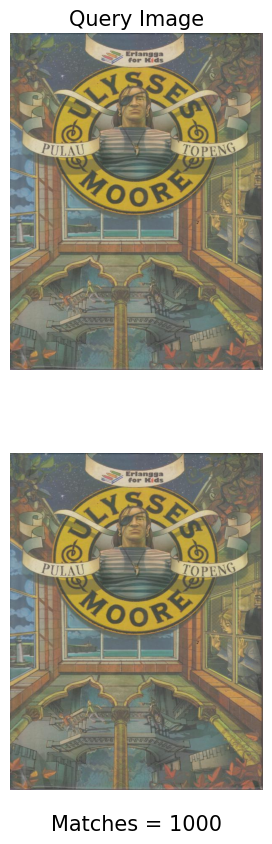

In [93]:
title_text = ""
plt.figure(figsize=(15,10))
query_image_number = 3

query_image = cv2.imread(predictions[query_image_number][0])
query_image = cv2.cvtColor(query_image, cv2.COLOR_BGR2RGB)
plt.subplot(2, 4, 1)
plt.axis('off')
plt.title("Query Image",fontsize=15)
plt.imshow(query_image)

# Check if predictions[query_image_number][1] is not empty
if predictions[query_image_number][1]:
    for i in range(min(predictions_count, len(predictions[query_image_number][1]))):
        title_text = ""
        img = cv2.imread(predictions[query_image_number][1][i][1])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        title_text = "Matches = " + str(predictions[query_image_number][1][i][0])
        plt.subplot(2,4,5+i)
        plt.axis('off')
        plt.text(0.5,-0.1,title_text,ha='center',va='center',fontsize=15,transform=plt.subplot(2,4,5+i).transAxes)
        plt.imshow(img)

plt.show()

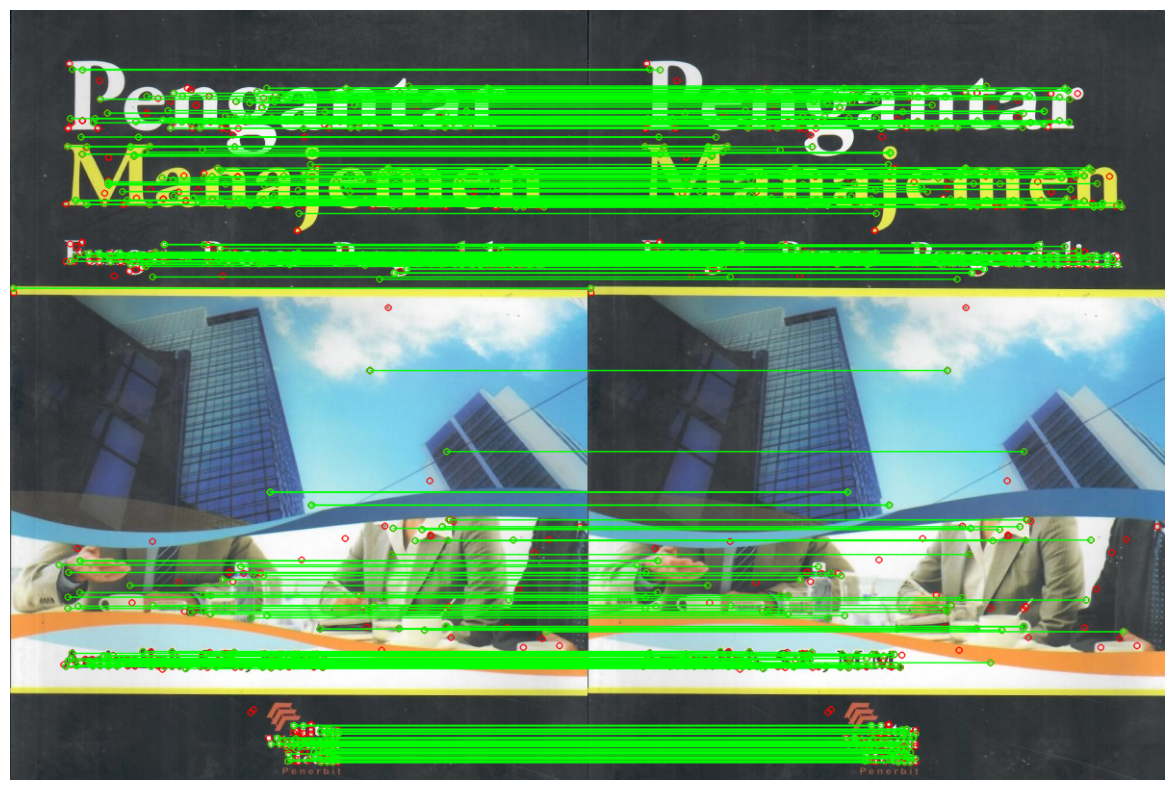

In [67]:
q_kp,q_des = gen_sift_features(query_image)
m_kp,m_des = gen_sift_features(top_prediction_image)
matches_old = flann.knnMatch(q_des,m_des,k=2)
matches = random.sample(matches_old, 500)

# Need to draw only good matches, so create a mask
matchesMask = [[0,0] for i in range(len(matches))]

# ratio test as per Lowe's paper
for i,(m,n) in enumerate(matches):
    if m.distance < lowe_ratio*n.distance:
        matchesMask[i]=[1,0]
        
draw_params = dict(matchColor = (0,255,0),
                   singlePointColor = (255,0,0),
                   matchesMask = matchesMask,
                   flags = 0)

kp_img = cv2.drawMatchesKnn(query_image,q_kp,top_prediction_image,m_kp,matches,None,**draw_params)

plt.figure(figsize=(20,10))
plt.axis('off')
plt.imshow(kp_img)
plt.show()